In [17]:
# %load_ext autoreload
# %autoreload 2

from memex import sram
import board
import busio
import time

spi = busio.SPI(board.SCLK,MOSI=board.MOSI,MISO=board.MISO)
spi.try_lock()
spi.configure(baudrate=1000000)
spi.unlock()

m1 = sram(spi,cs=board.D5,name="M1") # init m1

m1.write(0,70)

m1.read(0)

[70]

In [3]:
import RPi.GPIO as GPIO
GPIO.setmode(GPIO.BCM)            # choose BCM or BOARD  

#Set output enable high
GPIO.setup(26, GPIO.OUT) # set a port/pin as an output   
GPIO.output(26, 1)       # set port/pin value to 1/GPIO.HIGH/True  

#set hold pin high
GPIO.setup(19, GPIO.OUT) # set a port/pin as an output   
GPIO.output(19, 1)       # set port/pin value to 1/GPIO.HIGH/True  

In [ ]:
m1.fill(0x55)
m1.check(0x55)

In [84]:
t0 = time.time()
m1.fill(0x55)
print(m1.check(0x55))
t1 = time.time()
print(t1-t0)

0
0.7925646305084229


In [26]:
import adafruit_ina219
#adafruit_ina219._raw_calibration = 
i2c = busio.I2C(board.SCL, board.SDA)
ina219 = adafruit_ina219.INA219(i2c)

In [37]:
ina219.current

1.188

In [76]:
# script to check voltages
import pandas as pd
import numpy as np
import time

from multiprocessing import Process, Queue

Q = Queue()


def check_status(samp,
                 sensor = adafruit_ina219.INA219(i2c)):
    
    # samp --> number of data samples to take.
    data = [0]*samp
    t0 = time.time()
    for i in range(samp):
        
        t1 = time.time()
        volt = ina219.bus_voltage
        current = ina219.current
        
        data[i] = [volt, current, round(t1 - t0,2)] 
        
    df = pd.DataFrame(data, columns = ['Voltage','Current', 'Time'])
    Q.put(df)
    return df

def check_status_adc(samp, 
                     adc = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P0)):
    
    # samp --> number of data samples to take.
    data = [0]*samp
    t0 = time.time()
    for i in range(samp):
        
        t1 = time.time()
        volt = adc.voltage
        
        data[i] = [volt, round(t1 - t0,2)] 
        
    df = pd.DataFrame(data, columns = ['Voltage', 'Time'])
    Q.put(df)
    return df

def dummy_task():
    time.sleep(0.1)
    m1.fill(0x55)
    m1.check(0x55)

In [80]:
p = Process(target=check_status, args=(300,))
q = Process(target=dummy_task)

p.start()

#q.start()

# q.join()
# p.join()

df1 = Q.get()

0.004933333333333333


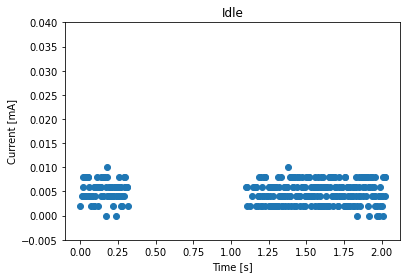

In [81]:
import matplotlib.pyplot as plt

print(np.mean(df1['Current']))

plt.scatter(df1['Time'], df1['Current'])
plt.ylabel('Current [mA]')
plt.xlabel('Time [s]')
plt.title('Idle')
plt.ylim(-0.005,0.04)
#plt.yscale('log')
plt.show()

In [454]:
print(np.mean(df1.query("0.2 < Time < 0.8")['Current']))

1.6379310344827587


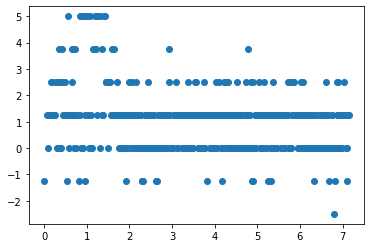

In [347]:
plt.scatter(df1['Time [s]'], df1['Power [mW]'])

In [12]:
df1

,Voltage,Current,Time
0,0.00000,0.002,0.00
1,0.00002,0.002,0.04
2,0.00000,0.002,0.05
3,0.00001,0.000,0.06
4,0.00001,0.002,0.06
...,...,...,...
395,-0.00001,0.002,2.08
396,0.00003,0.000,2.09
397,0.00003,0.002,2.09
398,0.00002,0.002,2.10


In [329]:
m1.check(1)

130866

In [1]:
import RPi.GPIO as GPIO
import time
import random
 
pins = (17,27,22) # R = 17, G = 27, B = 22

def setup():
    GPIO.setmode(GPIO.BCM)
    for i in pins:  # iterate on the RGB pins, initialize each and set to HIGH to turn it off (COMMON ANODE)
        GPIO.setup(i, GPIO.OUT)
        GPIO.output(i, GPIO.LOW)

In [24]:
#script to set voltages

import board
import busio
import time
import adafruit_mcp4728
import adafruit_ina219
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

def set_voltage_4(voltages = {'a':0, 'b':0, 'c':0, 'd':0}, 
                       timeout = 1,
                       dac = adafruit_mcp4728.MCP4728(busio.I2C(board.SCL, board.SDA)),
                       adc_ch0 = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P0),
                       adc_ch1 = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P1),
                       adc_ch2 = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P2),
                       adc_ch3 = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P3),
                       debug = False):
    
    """Set voltages using via a feedback loop from the MCP4728 (DAC) to ADS115 (ADC)
    Args:
      voltages(dict):  voltages to set. Must be a dictionary with keys 'a', 'b', 'c', and 'd'.
      sample_dict = {
        'a' : 0,
        'b' : 1.5,
        'c' : 2,
        'd' : 2.5
        }
        
      timeout(float): maximum time before feedback loop times out and breaks the while loop
      
      dac(adafruit_mcp4728.MCP4728): dac object
      
      adc_chx(adafruit_ads1x15.analog_in.AnalogIn): AnalogIn object for adc

    Returns:
        Final voltages read by ADC
    """
    
    adc_channels = {
        'a' : '0',
        'b' : '1',
        'c' : '2',
        'd' : '3'
        }
    
    
    for key in voltages:
        
        start = time.time()
        dac_ch = eval('dac.channel_%s'%(key))
        adc_ch = eval('adc_ch%s'%(adc_channels[key]))
        v = voltages[key]
        
        if v > 3.74: # exceeds maximum
            dac_ch.raw_value = 4095
            continue
        elif v < 0.001: # exceeds minimum
            dac_ch.raw_value = 0
            continue
        dac_ch.raw_value = int(v/5.1 * 4095) # set starting value
        
        while round(adc_ch.voltage,3) != round(v,3): # set voltage using feedback loop
            time.sleep(0.01)
            delta=0
            if adc_ch.voltage - v > 0.1:
                delta = -100
            elif adc_ch.voltage - v > 0.01:
                delta = -10
            elif adc_ch.voltage - v > 0.001:
                delta = -1

            if adc_ch.voltage - v < -0.1:
                delta = 100
            if adc_ch.voltage - v < -0.01:
                delta = 10
            elif adc_ch.voltage - v < -0.001:
                delta = 1

            if debug:
                print(adc_ch.voltage, dac_ch.raw_value, delta)

            if dac_ch.raw_value + delta > 4095: # exceeds maximum
                dac_ch.raw_value = 4095
                break
            elif dac_ch.raw_value + delta < 0: # exceeds minimum
                dac_ch.raw_value = 0
                break
            else:
                dac_ch.raw_value += delta

            if time.time() - start > timeout:
                print("Error in memex.set_voltage(): timed out")
                break
    
    
    return [[adc_ch0.voltage, dac.channel_a.raw_value], 
            [adc_ch1.voltage, dac.channel_b.raw_value], 
            [adc_ch2.voltage, dac.channel_c.raw_value], 
            [adc_ch3.voltage, dac.channel_d.raw_value]]

def timestamp():
    return int(time.time())

In [129]:
set_voltage_4(voltages = {'a':3.3, 'b':0, 'c':0, 'd':0}, debug=False, timeout=1)

[[3.3011007415997806, 2650],
 [0.555891964476455, 0],
 [0.5446416211432233, 0],
 [0.6345193639942626, 0]]

In [15]:
dac = adafruit_mcp4728.MCP4728(busio.I2C(board.SCL, board.SDA))
adc_ch0 = AnalogIn(ADS.ADS1115(busio.I2C(board.SCL, board.SDA)), ADS.P0)

In [16]:
dac.channel_a.value=65535
adc_ch0.voltage

3.8803684194463943

In [26]:
def vramp(start_v, end_v, step_size = 2,
         dac = adafruit_mcp4728.MCP4728(busio.I2C(board.SCL, board.SDA)),
         channel = 'a'):
    
    dac_ch = eval('dac.channel_%s'%(channel))
    
    #find/end beginning voltage
    start_raw_value = set_voltage_4(voltages = {'a':start_v}, debug=False)[0][1]
    end_raw_value = set_voltage_4(voltages = {'a':end_v}, debug=False)[0][1]
    
    delta = end_raw_value - start_raw_value
#     rate = duration/delta # increase a bit every time this unit passes
    
    for bit in range(int(delta/step_size)):

        dac_ch.raw_value = start_raw_value + step_size*bit

#         time.sleep(rate)
    
    return 0
    

In [145]:
p = Process(target=check_status_adc, args=(200,))
q = Process(target=vramp, args=(0,3.3,))

q.start()

p.start()

# q.join()
# p.join()

df1 = Q.get()

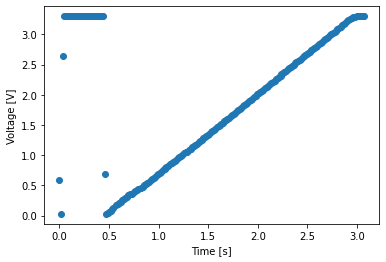

In [146]:
import matplotlib.pyplot as plt

plt.scatter(df1['Time'], df1['Voltage'])
plt.ylabel('Voltage [V]')
plt.xlabel('Time [s]')
#plt.ylim(-1,1)
#plt.yscale('log')
plt.show()